In [206]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd
from skimage import io,img_as_float
import torch.optim as optim
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
import model_conv
import model_conv_bigger
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')



In [207]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5


In [208]:
source_folder = '/home/axtr7550/Chromosome_project/real_images/for_axel/'


In [209]:
image_coords = pd.read_csv(source_folder + 'fork_outputs/positions_df.csv')
with open(source_folder + 'fork_outputs/train_cell_masks.txt', 'r') as f:
    raw_image_names = f.readlines()
    


In [210]:
image_names = [name.strip().split('/')[-1] for  name in raw_image_names]
image_names = np.array(image_names) 
image_names

array(['Pos01_img_100.tif', 'Pos01_img_101.tif', 'Pos02_img_100.tif',
       'Pos02_img_101.tif', 'Pos03_img_100.tif', 'Pos03_img_101.tif',
       'Pos04_img_100.tif', 'Pos04_img_101.tif', 'Pos05_img_100.tif',
       'Pos05_img_101.tif', 'Pos06_img_100.tif', 'Pos06_img_101.tif',
       'Pos07_img_100.tif', 'Pos07_img_101.tif', 'Pos08_img_100.tif',
       'Pos08_img_101.tif', 'Pos09_img_100.tif', 'Pos09_img_101.tif',
       'Pos10_img_100.tif', 'Pos10_img_101.tif'], dtype='<U17')

In [211]:
image_coords['img_name'] = image_names[image_coords['Image'].values.astype(int)]

In [212]:
image_coords

,Image,x,y,img_name
0,0,101,407,Pos01_img_100.tif
1,0,103,380,Pos01_img_100.tif
2,0,106,465,Pos01_img_100.tif
3,0,111,527,Pos01_img_100.tif
4,0,114,615,Pos01_img_100.tif
...,...,...,...,...
6443,19,681,738,Pos10_img_101.tif
6444,19,684,723,Pos10_img_101.tif
6445,19,737,966,Pos10_img_101.tif
6446,19,820,675,Pos10_img_101.tif


In [213]:
images = torch.zeros((20, 1041, 1302))

for i in range(20):
    img = io.imread(f'{source_folder}pool/{image_names[i]}').astype(np.int16)
    images[i, ...] = torch.tensor(img)[img.shape[0]//2:]

In [214]:
image = images[0]
plt.imshow(image, cmap='gray')
print(image.shape)


torch.Size([1041, 1302])


In [23]:
max_val , min_val = images.max(), images.min()

In [215]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [216]:
def final_loss(bce_loss, mu, logvar, beta=1):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    A beta here will affect how much the KLD matters

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

    return BCE + KLD*beta, BCE, KLD

In [217]:
def create_rois(image_coords, images):
    image_data = torch.tensor(image_coords[["Image", "x", "y"]].values, dtype=torch.int64)
    rois = torch.zeros((image_data.shape[0], 24, 24))
    
    for i in range(image_data.shape[0]):
        rois[i,:,:] = images[image_data[i,0], image_data[i,1]-12:image_data[i,1]+12, image_data[i,2]-12:image_data[i,2]+12]

    #rois = rois/rois.max()
    return rois


In [218]:
def create_rois_paired(image_coords, images):
    image_data = torch.tensor(image_coords[["Image", "x", "y"]].values, dtype=torch.int64)
    rois = torch.zeros((image_data.shape[0]//2,2, 24, 24))
    
    for i in range(0, image_data.shape[0],2):
        for j in range(2):
            try:
                rois[i,j,:,:] = images[image_data[i+j,0], image_data[i+j,1]-12:image_data[i+j,1]+12, image_data[i+j,2]-12:image_data[i+j,2]+12]
            except IndexError:
                continue
    #rois = rois/rois.max()
    return rois

In [228]:
def fit(model, rois, batch_size=128, beta=1, zdim=1):
    model.train()
    
    indeces = np.arange(rois.shape[0])
    np.random.shuffle(indeces)


    running_loss = 0.0
    for i in range(rois.shape[0]//batch_size):
        data = rois[indeces[i*batch_size:(i+1)*batch_size], ...]
        data = data.unsqueeze(1)
        data = data.to(device)

        optimizer.zero_grad()
        reconstruction, mu, logvar, _ = model(data)
        bce_loss = criterion(reconstruction, data) # Reconstructs the noisy image
        #se = torch.square(data - reconstruction)
        #se = se*mask
        #mse_loss = torch.sqrt(torch.sum(se))

        loss, BCE, KLD = final_loss(bce_loss, mu, logvar, beta)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        save_mod = (1+1*epoch//10) if epoch < 100 else 10*(epoch//100)

        if (rois.shape[0]//batch_size - 1) and (epoch % save_mod == 0):
            num_rows = 8
            both = torch.cat((data.view(batch_size, 1, 24, 24)[:8], 
                                reconstruction.view(batch_size, 1, 24, 24)[:8]))
            save_image(both.cpu(), f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/VAE_real_scale-1-7_beta{beta}_data_1_{epoch}_zdim_{zdim}.png", nrow=num_rows, pad_value=1)

    train_loss = running_loss/rois.shape[0]
    return train_loss

In [221]:
model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=1).to(device)
lr = 0.001
optimizer = optim.AdamW(model.parameters(), lr=lr)
#criterion = nn.BCELoss(reduction='sum')
criterion = nn.MSELoss(reduction='sum')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=0.2,
                                                    patience=20,
                                                    min_lr=5e-5)


type: tensor() missing 1 required positional arguments: "data"

In [30]:
rois = create_rois(image_coords, images)
#scaling = torch.quantile(torch.quantile(rois, 0.95, axis=1, keepdim=True), 0.95, axis=1, keepdim=True)
scaling = rois.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
means = rois.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
stds = rois.std(dim=1, keepdim=True).mean(dim=2, keepdim=True)
scaling = torch.quantile(rois, 0.99)
rois = (rois - means)/(stds)
rois = rois.clamp(-1.5,1.5)
rois = rois*0.33333+0.5
rois = rois.clamp(0.0,1)

#rois = rois/scaling


In [223]:
rois = create_rois(image_coords, images)
#scaling = torch.quantile(torch.quantile(rois, 0.95, axis=1, keepdim=True), 0.95, axis=1, keepdim=True)
means = rois.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
stds = rois.std(dim=1, keepdim=True).mean(dim=2, keepdim=True)
rois = (rois - means)/(stds)
rois = rois.clamp(-1, 7)
rois = rois*1/8+1/8
rois = rois.clamp(0.0,1)
i = 1000
plt.imshow(rois[i], cmap='gray', vmin=0, vmax=1)
print(rois[i].max())


tensor(1.)


tensor(567.) tensor(113.)
tensor(17.8689) tensor(-3.4159)
tensor(7.0711) tensor(-1.4600)
tensor(7.0711) tensor(-1.4600)
tensor(0.8071) tensor(-0.0460)
tensor(0.8071) tensor(0.)
tensor(0.8071)


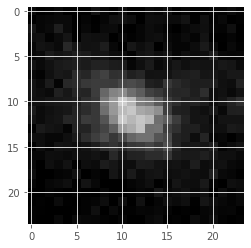

In [91]:
rois = create_rois(image_coords, images)
i = 150
print(rois[i].max(), rois[i].min())

#scaling = torch.quantile(torch.quantile(rois, 0.95, axis=1, keepdim=True), 0.95, axis=1, keepdim=True)
means = rois.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)

stds = rois.std(dim=1, keepdim=True).mean(dim=2, keepdim=True)

rois = (rois - means)/(stds)
print(rois.max(), rois.min())

print(rois[i].max(), rois[i].min())

rois = rois.clamp(-10, 10)
print(rois[i].max(), rois[i].min())

rois = rois*1/10+1/10
print(rois[i].max(), rois[i].min())

rois = rois.clamp(0.0,1)
print(rois[i].max(), rois[i].min())

plt.imshow(rois[i], cmap='gray', vmin=0, vmax=1)
print(rois[i].max())


In [187]:
mask = torch.ones([1,1, 24, 24])

for i in range(24):
    for j in range(24):
        mask[0,0,i,j] *= 1/(np.sqrt((12-i)**2+(12-j)**2)+ 2)
mask = mask*10000
mask = mask.to(device)

In [100]:
def scaled_mse_loss(y_true, y_pred):
    print(mask)
    se = torch.sqrt((y_true - y_pred) ** 2)
    se = se*mask
    return torch.sum(se)


tensor(0.5000) tensor(0.0527)


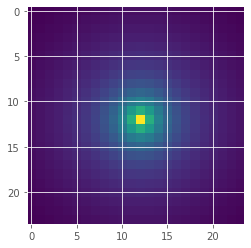

In [123]:
plt.imshow(mask[0,0,...])
print(mask.cpu().max(), mask.cpu().min())


In [129]:
se = torch.sqrt((rois - rois*mask) ** 2)
se = se*mask
mse_loss = torch.sum(se)
mse_loss



tensor(44723.4922)

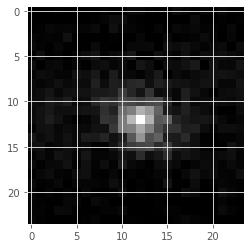

In [152]:
masked_roi = rois*mask
plt.imshow(masked_roi[10,...], cmap='gray')



In [205]:
paired_rois = create_rois_paired(image_coords, images)
#scaling = torch.quantile(torch.quantile(rois, 0.95, axis=1, keepdim=True), 0.95, axis=1, keepdim=True)
means = paired_rois.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
stds = paired_rois.std(dim=2, keepdim=True).mean(dim=3, keepdim=True)
paired_rois = (paired_rois - means)/(stds)
paired_rois = paired_rois.clamp(-1, 7)
paired_rois = paired_rois*1/8+1/8
paired_rois = paired_rois.clamp(0.0,1)



type: can't assign a numpy.ndarray to a torch.FloatTensor

In [107]:
for i in range(1000, 1010, 2):
    fig, axs = plt.subplots(2)

    axs[0].imshow(paired_rois[i,0], cmap='gray', vmin=0, vmax=1)

    axs[1].imshow(paired_rois[i,1], cmap='gray', vmin=0, vmax=1)
    fig.suptitle(i)

In [108]:
plt.close('all')

In [229]:
batch_size = 128
#criterion = scaled_mse_loss

train_loss = []
for beta in [1]:
    for zdim in [2]:
        curr = 0
        epochs = 5000

        
        model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=zdim).to(device)
        lr = 0.001
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        #criterion = nn.BCELoss(reduction='sum')
        criterion = nn.MSELoss(reduction='sum')
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            mode='min',
                                                            factor=0.2,
                                                            patience=20,
                                                            min_lr=5e-6)


        for epoch in range(curr, curr+epochs+1):
            print(f"Epoch {epoch+1} of {epochs}")
            train_epoch_loss = fit(model, rois, batch_size=batch_size, beta=beta, zdim=zdim)
            train_loss.append(train_epoch_loss)
            print(f"Train Loss: {train_epoch_loss:.4f}")
            if epoch % 5000 == 0:
                torch.save(model.state_dict(), f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_-1-7scaling_data_z_only_1_45deg_beta{beta}_{epoch}_zdim{zdim}_test_mask_loss.pt")



Epoch 1 of 5000
Train Loss: 13.5044
Epoch 2 of 5000
Train Loss: 6.5918
Epoch 3 of 5000
Train Loss: 6.1960
Epoch 4 of 5000
Train Loss: 6.0584
Epoch 5 of 5000
Train Loss: 5.9597
Epoch 6 of 5000
Train Loss: 5.9370
Epoch 7 of 5000
Train Loss: 5.9106
Epoch 8 of 5000
Train Loss: 5.8840
Epoch 9 of 5000
Train Loss: 5.8707
Epoch 10 of 5000
Train Loss: 5.8622
Epoch 11 of 5000
Train Loss: 5.8619
Epoch 12 of 5000
Train Loss: 5.8533
Epoch 13 of 5000
Train Loss: 5.8493
Epoch 14 of 5000
Train Loss: 5.8303
Epoch 15 of 5000
Train Loss: 5.8132
Epoch 16 of 5000
Train Loss: 5.8172
Epoch 17 of 5000
Train Loss: 5.8359
Epoch 18 of 5000
Train Loss: 5.8250
Epoch 19 of 5000
Train Loss: 5.8223
Epoch 20 of 5000
Train Loss: 5.8240
Epoch 21 of 5000
Train Loss: 5.7995
Epoch 22 of 5000
Train Loss: 5.8056
Epoch 23 of 5000
Train Loss: 5.8045
Epoch 24 of 5000
Train Loss: 5.8096
Epoch 25 of 5000
Train Loss: 5.8194
Epoch 26 of 5000
Train Loss: 5.7649
Epoch 27 of 5000
Train Loss: 5.7969
Epoch 28 of 5000
Train Loss: 5.7815


In [236]:
%matplotlib qt5
 
with torch.no_grad():

    #model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=1).to(device)
    #model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_-1-7scaling_data_z_only_1_45deg_beta1_5000.pt"))
    #model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_-1-7scaling_data_z_only_1_45deg_beta1_0_zdim1_test_mask_loss.pt"))
    n_steps =20

    xyz = torch.ones((n_steps,3))*32
    zs = torch.linspace(-1, 1, n_steps).view(-1,1).to(device)
    model.eval()

    images = model.decoder(zs)
    mus, logvar = model.encoder(images)
    images = images.cpu().detach().numpy()

    fig, axs = plt.subplots(2,10, figsize=(25,5))
    for j in range(images.shape[0]):
        ax = axs[j//10][j%10]
        ax.imshow(images[j,0,...], cmap='gray')
        ax.axis('off')
        ax.set_title(f'z = {zs[j].item():.2} ({mus[j].item():.2}, {logvar[j].item():.2})')

    #plt.savefig(f'/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/figures/traversal_VAE_real_-1-7scaling_data_z_only_1_45deg_beta1_5000', transparent=False)


type: mat1 and mat2 shapes cannot be multiplied (20x1 and 2x2304)

In [87]:
with torch.no_grad():
    model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=1).to(device)
    model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_-1-7scaling_data_z_only_1_45deg_beta1_5000.pt"))

    model.eval()
    unshifted = paired_rois[:,0,:,:] 
    out, mu, logVar, z = model(unshifted.unsqueeze(1).to(device))
    latent_space_unshifted = mu.detach().cpu().numpy()
    latent_space_unshifted = latent_space_unshifted[np.logical_not(np.isnan(latent_space_unshifted))]
    shifted = paired_rois[:,1,:,:] 
    out, mu, logVar, z = model(shifted.unsqueeze(1).to(device))
    latent_space_shifted = mu.detach().cpu().numpy()
    latent_space_shifted = latent_space_shifted[np.logical_not(np.isnan(latent_space_shifted))]



In [231]:
with torch.no_grad():
    #model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=1).to(device)
    #model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_-1-7scaling_data_z_only_1_45deg_beta1_5000.pt"))

    model.eval()
    out, mu, logVar, z = model(rois.unsqueeze(1).to(device))
    latent_space = mu.detach().cpu().numpy()


In [242]:
plt.scatter(latent_space[:, 0], latent_space[:, 1], alpha=0.1)
plt.title('Latent space real images -1-7')

Text(0.5, 1.0, 'Latent space real images -1-7')

In [202]:


model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=2).to(device)
model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_-1-7scaling_data_z_only_1_45deg_beta1_5000.pt"))
#model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_-1-7scaling_data_z_only_1_45deg_beta1_0_zdim2_test_mask_loss.pt"))


<All keys matched successfully>

In [237]:

with torch.no_grad():
    n_steps = 10
    z_dim = 2
    xyz = torch.ones((n_steps,3))*32
    zs = torch.linspace(-1, 1, n_steps).view(-1,).to(device)

    if z_dim == 2:
        zs = torch.stack((zs.repeat(n_steps), zs.repeat_interleave(n_steps)), dim=1)

    model.eval()
    images = model.decoder(zs)
    mus, logvar = model.encoder(images)
    images = images.cpu().detach().numpy()

    fig, axs = plt.subplots(10,10, figsize=(10,10), layout='tight')
    for j in range(images.shape[0]):
        ax = axs[j//10][j%10]
        ax.imshow(images[j,0,...], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')



In [238]:
# Remove large outliers in latent space
fig, ax = plt.subplots()
plt.hist(latent_space_unshifted, bins=100, label='unshifted')
plt.hist(latent_space_shifted, bins=100, alpha=0.5, label='shifted')

ax.set_title('Latent_space')
plt.legend()


type: name 'latent_space_unshifted' is not defined

In [109]:
import sklearn.linear_model as lm
fig, ax = plt.subplots()
diff = latent_space_shifted-latent_space_unshifted
lr = lm.LinearRegression().fit(latent_space_unshifted.reshape(-1,1), diff.reshape(-1,1))

plt.plot(latent_space_unshifted, diff, 'o')
plt.plot(latent_space_unshifted, (lr.intercept_ + lr.coef_ * latent_space_unshifted)[0,:], 'b')


In [103]:
lr.score(latent_space_unshifted.reshape(-1,1), diff.reshape(-1,1))

0.3748770480529363

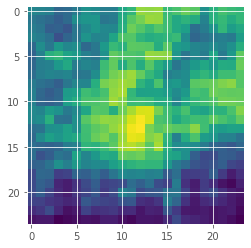

In [58]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

n_steps = 1000
zs = torch.linspace(-4, 4, n_steps).view(-1,1).to(device)

model.eval()

images = model.decoder(zs)
cpu_images = images.detach().to('cpu').numpy()
plt.imshow(cpu_images[0, 0,...])


In [ ]:
slider =widgets.IntSlider(
    min=0,
    max=rois.shape[0]-1,
    step=1,
    description='Slider:',
    value=3
)
btn = widgets.Button(description='Bad')



In [85]:
cpu_rois = rois.to('cpu').numpy()

model.eval()
rois = rois.to(device)
mu, logvar = model.encoder(rois.unsqueeze(1))
mu = mu.detach().cpu().numpy()

torch.Size([6448, 24, 24])


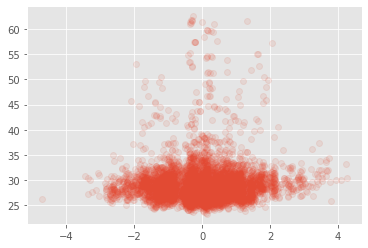

In [183]:


roi_base = create_rois(image_coords, images)
print(roi_base.shape)
intensity = roi_base.sum(axis=1).sum(axis=1)

plt.plot(mu,intensity , 'o', alpha=0.1)

In [201]:
out = widgets.Output(layout=Layout(width='70%', height='500px'))

def on_value_changed(val):
    with out:
        out.clear_output()
        i = slider.value
        image = cpu_rois[i,...]
        plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
        plt.axis('off')
        plt.show()
        
slider.observe(on_value_changed, names='value')

,Image,x,y
img_name,,,
Pos01_img_100.tif,333,333,333
Pos01_img_101.tif,308,308,308
Pos02_img_100.tif,354,354,354
Pos02_img_101.tif,340,340,340
Pos03_img_100.tif,246,246,246
Pos03_img_101.tif,239,239,239
Pos04_img_100.tif,372,372,372
Pos04_img_101.tif,351,351,351
Pos05_img_100.tif,408,408,408


In [30]:
image_coords

,Image,x,y,img_name
0,0,101,407,Pos01_img_100.tif
1,0,103,380,Pos01_img_100.tif
2,0,106,465,Pos01_img_100.tif
3,0,111,527,Pos01_img_100.tif
4,0,114,615,Pos01_img_100.tif
...,...,...,...,...
6443,19,681,738,Pos10_img_101.tif
6444,19,684,723,Pos10_img_101.tif
6445,19,737,966,Pos10_img_101.tif
6446,19,820,675,Pos10_img_101.tif


In [202]:
indeces_to_remove = []
roi_base = create_rois(image_coords, images)
intensity = roi_base.sum(axis=1).sum(axis=1)

def on_button_click(b):
    with out:
        plt.plot(mu,intensity , 'o', alpha=0.05)
        plt.plot(mu[slider.value],intensity[slider.value], 'bo', alpha=1)
        plt.show()

btn.on_click(on_button_click)


In [203]:
display(out)
display(btn)
display(slider)


Output(layout=Layout(height='500px', width='70%'))

Button(description='Bad', style=ButtonStyle())

IntSlider(value=3, description='Slider:', max=6001)

In [188]:
slider_latent =widgets.IntSlider(
    min=0,
    max=999,
    step=1,
    description='Slider:',
    value=3
)
#btn = widgets.Button(description='Bad')

out_latent = widgets.Output(layout=Layout(width='70%', height='300px'))

def on_latent_value_changed(val):
    with out_latent:
        out_latent.clear_output()
        i = slider_latent.value
        image = cpu_images[i,0,...]
        plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
        plt.axis('off')
        plt.show()
        
slider_latent.observe(on_latent_value_changed, names='value')


In [54]:
display(out_latent)
display(slider_latent)


type: name 'out_latent' is not defined